# Imports

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from google.colab.patches import cv2_imshow

print('Imports done')

Imports done


# Data

In [ ]:
class LicensePlateDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transforms=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  # Adjust for your image format

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        w, h = img.size  # Get image dimensions

        # Load corresponding annotation file
        annot_name = img_name.replace('.jpg', '.txt')
        annot_path = os.path.join(self.annot_dir, annot_name)

        with open(annot_path, 'r') as f:
            annotation = f.readline().strip().split()

        # Parse the annotation file
        _, x_center, y_center, box_width, box_height = map(float, annotation)

        # Convert normalized coordinates to absolute pixel values
        x_center *= w
        y_center *= h
        box_width *= w
        box_height *= h

        # Convert (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
        x_min = x_center - (box_width / 2)
        y_min = y_center - (box_height / 2)
        x_max = x_center + (box_width / 2)
        y_max = y_center + (box_height / 2)

        # Create bounding box and label
        boxes = torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)  # We assume only 1 class: license plate

        # Create the target dictionary expected by Faster R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
        }

        # Apply any specified transformations
        if self.transforms:
            img = self.transforms(img)

        return img, target


In [ ]:
'''
Image Transforms
'''

# Define the image transformations (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
])

# Initialize the datasets with transformations
train_dataset = LicensePlateDataset(
    image_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/train/images',
    annot_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/train/labels',
    transforms=transform
)

val_dataset = LicensePlateDataset(
    image_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/valid/images',
    annot_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/valid/labels',
    transforms=transform
)

test_dataset= LicensePlateDataset(
    image_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/test/images',
    annot_dir='/content/drive/MyDrive/Escola/UAB/3r/Vision/License_Plate_Detection.v1i.yolov9/test/labels',
    transforms=transform
)
'''
Dataloader
'''
def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoaders for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# Model

In [ ]:
'''
Faster R-CNN Model
'''
# Load a pre-trained Faster R-CNN model
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # Use the most up-to-date weights
model = fasterrcnn_resnet50_fpn(pretrained=weights)

# Modify the model's head to have the correct number of classes (license plate + background)
num_classes = 2  # 1 for license plate, 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Send model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

#
best_model_path = "/content/drive/MyDrive/Escola/UAB/3r/Vision/best_faster_rcnn_model.pth"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 114MB/s] 


## Training

In [ ]:
# Function to compute IoU for a batch of predictions and targets
def compute_batch_iou(pred_boxes, target_boxes):
    iou_scores = []
    for pred, target in zip(pred_boxes, target_boxes):
        iou = box_iou(pred, target)  # Compute IoU between predicted and target boxes
        if len(iou) > 0:
            iou_scores.append(iou.max().item())  # Get the max IoU for each prediction-target pair
        else:
            iou_scores.append(0.0)  # No prediction matched
    return iou_scores

# Validation function (modified to handle predictions and compute IoU)
def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_iou = []
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get the model's predictions (instead of loss)
            predictions = model(images)

            # Collect IoU scores for each image in the batch
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu()  # Predicted bounding boxes
                target_boxes = target['boxes'].cpu()  # Ground truth bounding boxes

                # Calculate IoU between predicted and target boxes
                iou_scores = compute_batch_iou([pred_boxes], [target_boxes])

                # Append the highest IoU score for each image
                total_iou.extend(iou_scores)
                num_samples += 1

    # Calculate the mean IoU across the validation set
    mean_iou = sum(total_iou) / len(total_iou) if len(total_iou) > 0 else 0.0
    print(f"Mean IoU over the validation set: {mean_iou:.4f}")

    return mean_iou

# Example Training Loop with Validation
num_epochs = 10
best_val_iou = 0.0  # Initialize to track best IoU

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()  # Zero gradients

        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Validation step after each epoch
    mean_val_iou = validate(model, val_loader, device)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation IoU: {mean_val_iou:.4f}')

    # Save the model if the validation IoU is the best so far
    if mean_val_iou > best_val_iou:
        print(f'Validation IoU improved from {best_val_iou:.4f} to {mean_val_iou:.4f}. Saving model...')
        best_val_iou = mean_val_iou
        torch.save(model.state_dict(), best_model_path)

print(f'Training complete. Best model saved at {best_model_path} with IoU: {best_val_iou:.4f}')


KeyboardInterrupt: 

## Recover best

In [ ]:
# Initialize the model architecture
model = fasterrcnn_resnet50_fpn(weights=weights)

# Replace the box predictor to match your classes (if necessary)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2  # 1 for license plate, 1 for background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))

# Move the model to the correct device
model.to(device)

# Set the model to evaluation mode (for testing or inference)
model.eval()

<ipython-input-11-67a29a01f962>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Tests

In [ ]:
# Function to compute IoU for a batch of predictions and targets
def compute_batch_iou(pred_boxes, target_boxes):
    iou_scores = []
    for pred, target in zip(pred_boxes, target_boxes):
        iou = box_iou(pred, target)  # Compute IoU between predicted and target boxes
        if len(iou) > 0:
            iou_scores.append(iou.max().item())  # Get the max IoU for each prediction-target pair
        else:
            iou_scores.append(0.0)  # No prediction matched
    return iou_scores

# Function to test the model on the test set and calculate evaluation metrics
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    total_iou = []
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in test_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get the model's predictions
            predictions = model(images)

            # Collect IoU scores for each image in the batch
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu()  # Predicted bounding boxes
                target_boxes = target['boxes'].cpu()  # Ground truth bounding boxes

                # Calculate IoU between predicted and target boxes
                iou_scores = compute_batch_iou([pred_boxes], [target_boxes])

                # Append the highest IoU score for each image
                total_iou.extend(iou_scores)
                num_samples += 1

    # Calculate the mean IoU across the test set
    mean_iou = sum(total_iou) / len(total_iou) if len(total_iou) > 0 else 0.0
    print(f"Mean IoU over the test set: {mean_iou:.4f}")

    return mean_iou

# Run the test function
mean_iou = test_model(model, test_loader, device)
print(f'Evaluation complete. Mean IoU: {mean_iou:.4f}')

Mean IoU over the test set: 0.8583
Evaluation complete. Mean IoU: 0.8583


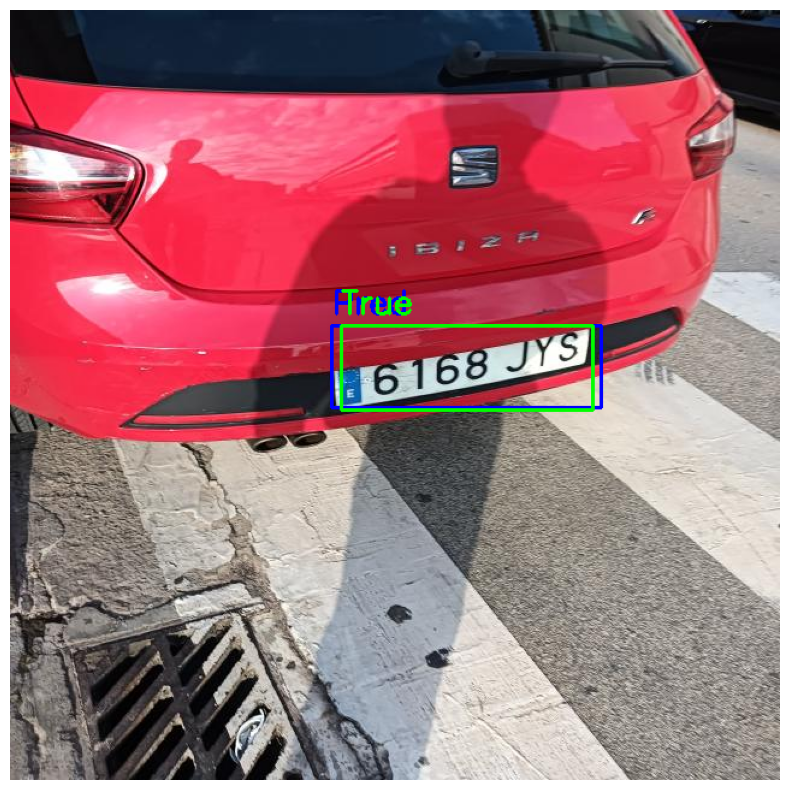

In [ ]:
# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, color, label):
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
        cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Function to visualize a single test image with predicted and true boxes
def visualize_prediction(model, test_dataset, idx, device):
    model.eval()  # Set model to evaluation mode

    # Load image and target (ground truth)
    image, target = test_dataset[idx]  # idx specifies which image to visualize
    image = [image.to(device)]  # Move image to device

    # Make prediction
    with torch.no_grad():
        prediction = model(image)

    # Convert the image back to numpy format for visualization
    img_np = image[0].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) format
    img_np = np.clip(img_np * 255, 0, 255).astype('uint8')  # Convert from [0, 1] to [0, 255] and ensure uint8 format

    # Convert image from RGB to BGR format for OpenCV (if needed)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Get predicted and true boxes
    pred_boxes = prediction[0]['boxes'].cpu().numpy()  # Predicted boxes
    true_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes

    # Draw predicted boxes in red
    draw_boxes(img_np, pred_boxes, color=(255, 0, 0), label='Pred')

    # Draw ground truth boxes in green
    draw_boxes(img_np, true_boxes, color=(0, 255, 0), label='True')

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))  # Convert back to RGB for display
    plt.axis('off')  # Hide the axes
    plt.show()

# Example usage: Visualize the 5th image in the test dataset
visualize_prediction(model, test_dataset, idx=5, device=device)
